# Discover project Ames housing data

# Aanpak van dit project

## Door: Eric Ruis, Laurence Frank

Eerste fase is het begrijpen van de data set. Wat betekenen de variabelen (domein kennis)? Hoe zijn de variablen verdeeld? Zijn er missende waarden, outliers? Welke variabelen correleren met elkaar en met de uitkomst maat?



## Business Understanding

Het doel is om de prijs van huizen te voorspellen op basis van een tachtigtal kenmerken van de huizen. 



## Data Understanding

De data staan uitgebreid beschreven op deze Kaggle webpagina: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


De data set bestaat uit 80 variabelen die verschillende aspecten van het huis beschrijven in de volgende categorieen: de kenmerken van het huis zelf (indeling, oppervlak, stijl, bouwjaar, kwaliteit, etc), kenmerken van de grond waarop het huis staat en kenmerken van de buurt. 



We beginnen met een setup van python met de meest gebruikte libraries.

In [49]:
# PEP-8: group imports from standard library first, alphabetical order
from pathlib import Path # use pathlib for working with paths
import sys
import tarfile
import warnings

# imports from third-party modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests.compat import urljoin
import sklearn
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# leaderboard to compare our results
LEADERBOARD = 'https://github.com/jads-nl/discover-projects/blob/main/ames-housing/house-prices-advanced-regression-techniques-publicleaderboard.csv?raw=true'

# Initialize the random number generator at a specific state to be able reproduce
# the random selections in this notebook
SEED = np.random.seed(42)


**Importeren van de data**

In [41]:
ames = pd.read_csv("https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true")
ames.shape

(2930, 82)

In [42]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Missende waarden checken

Visualize missing values of a `pandas` data frame: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

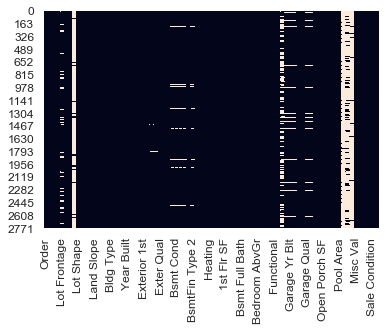

In [43]:
sns.heatmap(ames.isnull(), cbar=False)

### Exploreer de variabelen

Op basis van "gezond verstand" gaan we na of bepaalde variabelen een verband hebben met de uitkomst variabele `SalePrice`. Dit is een globale check op de data om te kijken of we variabelen waar nauwelijks informatie in zit, weg kunnen laten. 

We zien al in de informatie over de data, hierboven, dat `Alley`, `Pool QC` en `Misc Feature` nauwelijks observaties hebben. 

Beschrijvende statistieken van de training data set. Bekijk de verdeling van de uitkomst variabele in verschillende subgroepen, zoals buurt, staat van het huis, type woning, Condition2


#### Verdeling van de uitkomstvariabele

Verdeling van de uitkomst variabele, `SalePrice` bekijken. 

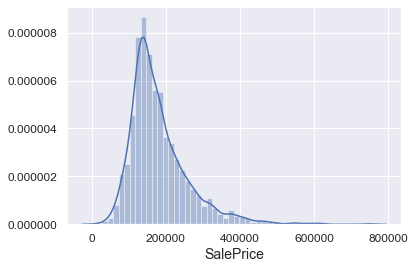

In [44]:
sns.distplot(ames['SalePrice'])

In [45]:
ames['SalePrice'].skew()

1.7435000757376466

Het is duidelijk dat de verkoop prijs scheef verdeeld is. In de modelering fase nemen we de log van deze variabele. 

#### Beschrijving van de categorische variabelen

In [22]:
ames.describe(include = np.object)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2930,2930,198,2930,2930,2930,2930,2930,2930,2930,...,2773,2771,2771,2771,2930,13,572,106,2930,2930
unique,7,2,2,4,4,3,5,3,28,9,...,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2273,2918,120,1859,2633,2927,2140,2789,443,2522,...,1731,1231,2615,2665,2652,4,330,95,2536,2413


### Beschrijving van de numerieke variabelen

In [23]:
ames.describe(exclude = np.object)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


#### Correlatie tussen de numerieke variabelen en `SalePrice`

We vragen een correlatie heatmap op van de gehele data set. We kiezen voor een heatmap vanwege het grote aantal variabelen (62).

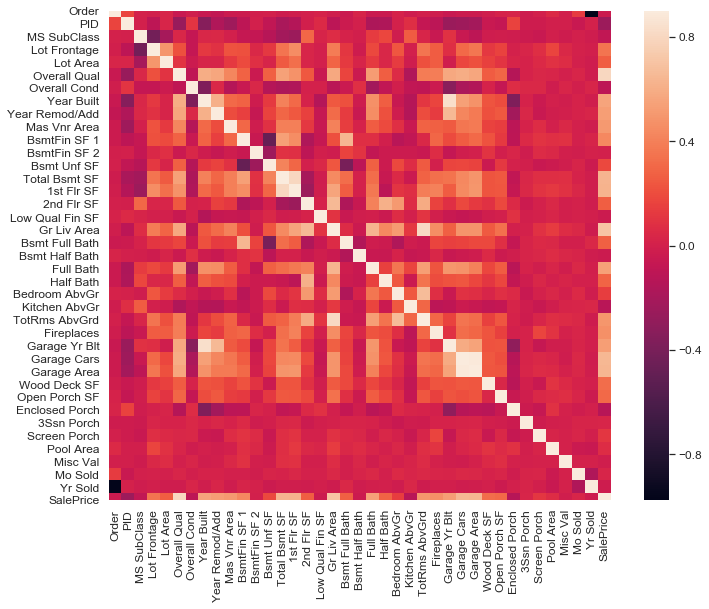

In [46]:
corrmat = ames.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True);

**Conclusies van de correlatiematrix**

De volgende variabelen hebben een hoge correlatie met SalePrice:
`Overall Qual`, `Year Built`, `Year Remod/Add`, `Total Bsmt SF`, `1st Flr SF`, `Gr Liv Area`, `Garage Cars`, `Garage Area`

De correlaties zijn overwegend positief, er zijn een aantal hoge positieve correlaties (> 0.75), maar er zijn geen hoge negatieve correlaties en relatief minder negatieve correlaties. 

Verder valt op dat er een aantal predictoren onderling hoge correlaties hebben:
`Garage Year Blt` en `Year Built`;
`Gr. Liv Area` en `TotRms AbvGrd`;
`Garage Cars` en `Garage Area`;
`1st Flr SF` en `Total Bsmt SF`.

Het is toch lastig om in de heatmap een aantal variabelen te selecteren met die een hoge correlatie hebben met de uitkomst maat. Daarom een heatmap van de 10 grootste correlaties. 

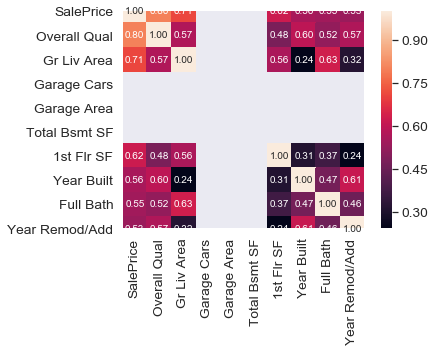

In [47]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(ames[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We inspecteren de verdeling van de continue variabelen die voorkomen in de vorige heatmap plot van de 10 hoogste correlaties met de uitkomst maat. 

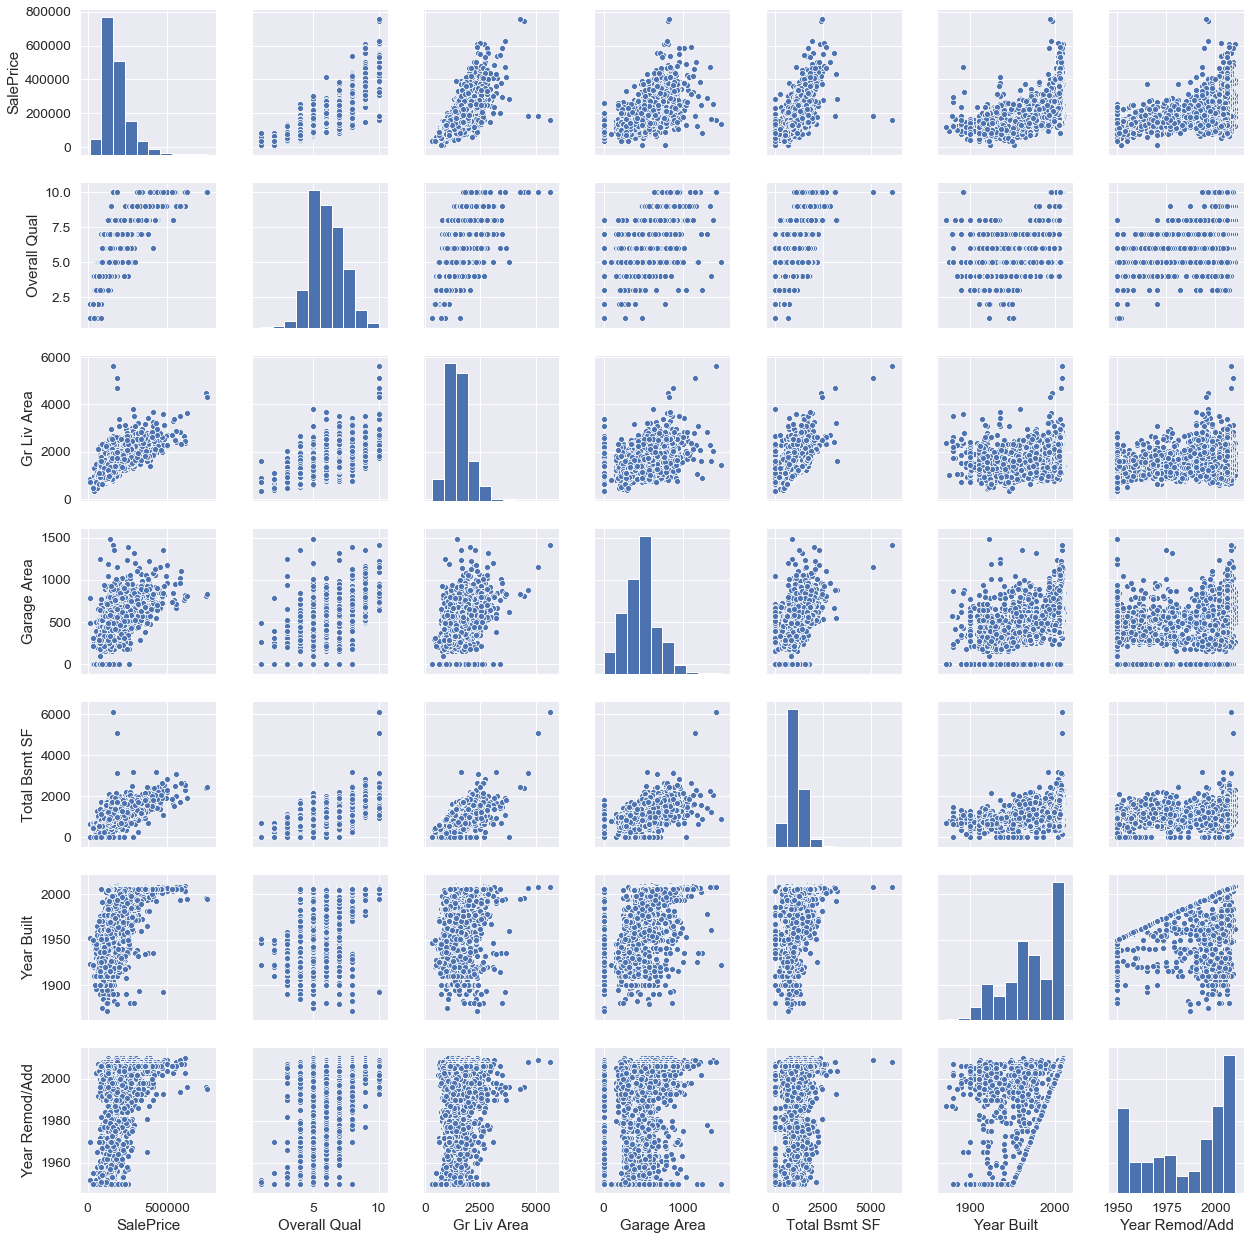

In [48]:
sns.pairplot(ames[['SalePrice','Overall Qual','Gr Liv Area','Garage Area','Total Bsmt SF',
                        'Year Built', 'Year Remod/Add']])

### Exploreren van de relatie tussen kenmerken van de huizen en de verkoopprijs

Op basis van gezond verstand verwachten we bijvoorbeeld dat de buurt (`Neighborhood`) waarin een huis staat, invloed heeft op de verkoopprijs. Dat geldt ook voor het type huis (`House Style`).

Van een aantal andere kenmerken, verwachten we dat er niet veel samenhang met de verkoopprijs zal zijn, zoals bijvoorbeeld `Condition2` (Proximity to various conditions, if more than one is present)). Deze variabele gaat waarschijnlijk niet veel informatie toevoegen ten opzichte van Condition1.

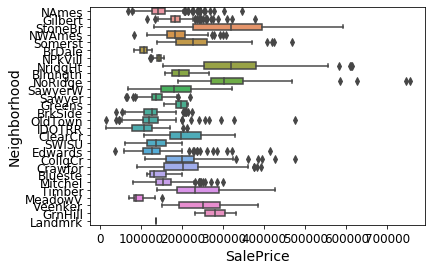

In [24]:
ax = sns.boxplot(x="SalePrice", y="Neighborhood", data=ames, orient="h")

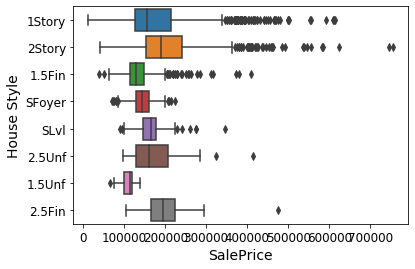

In [25]:
ax = sns.boxplot(x="SalePrice", y="House Style", data=ames, orient="h")

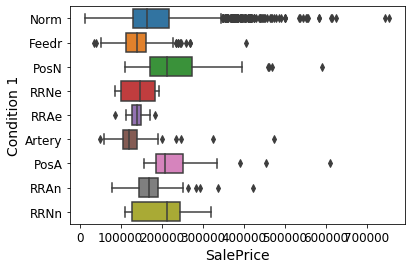

In [26]:
ax = sns.boxplot(x="SalePrice", y="Condition 1", data=ames, orient="h")

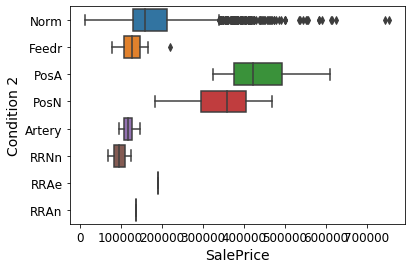

In [27]:
ax = sns.boxplot(x="SalePrice", y="Condition 2", data=ames, orient="h")

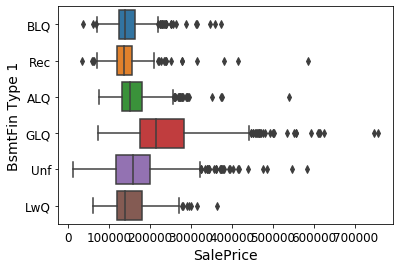

In [28]:
ax = sns.boxplot(x="SalePrice", y="BsmtFin Type 1", data=ames)

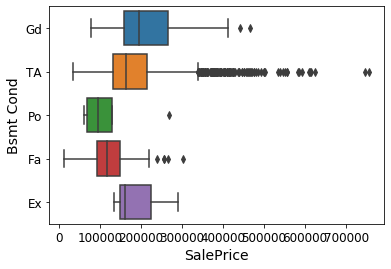

In [29]:
ax = sns.boxplot(x="SalePrice", y="Bsmt Cond", data=ames, orient="h")

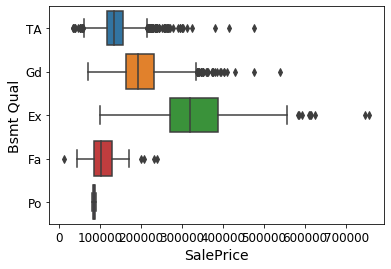

In [30]:
ax = sns.boxplot(x="SalePrice", y="Bsmt Qual", data=ames, orient="h")

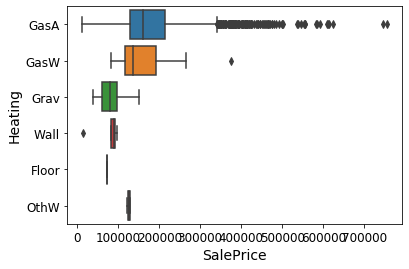

In [31]:
ax = sns.boxplot(x="SalePrice", y="Heating", data=ames, orient="h")

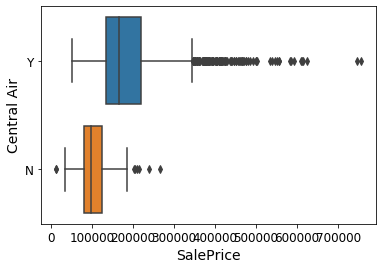

In [32]:
ax = sns.boxplot(x="SalePrice", y="Central Air", data=ames, orient="h")

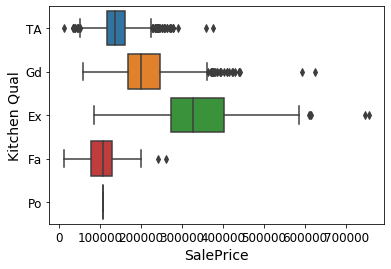

In [33]:
ax = sns.boxplot(x="SalePrice", y="Kitchen Qual", data=ames, orient="h")

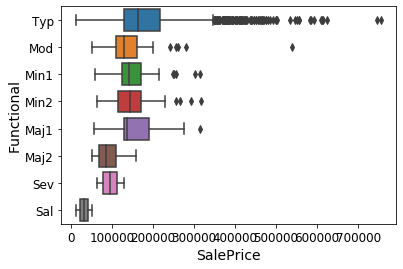

In [34]:
ax = sns.boxplot(x="SalePrice", y="Functional", data=ames, orient="h")

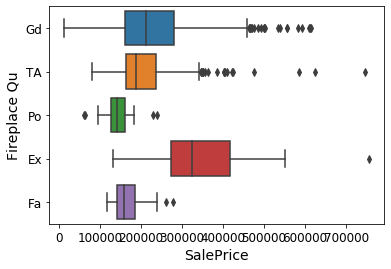

In [35]:
ax = sns.boxplot(x="SalePrice", y="Fireplace Qu", data=ames, orient="h")

Er worden een aantal categorische variabelen niet meegenomen omdat we bij het exploreren van de boxplots hebben gezien dat deze variabelen niet veel verband lijken te hebben met de uitkomst variabele SalesPrice.
Ook laten we de variabelen `Order` en `PID` weg omdat dit administratieve nummers van de huizen zijn, die geen relatie hebben met de uitkomst maat.

In [36]:
dropvars = ["Order", "PID", "Condition 1", "Condition 2", "BsmtFin Type 1", "BsmtFin Type 2", "Bsmt Qual", "Bsmt Cond", 
            "Bsmt Exposure", "Pool QC", "Fence", "Misc Feature", "Alley", "Heating", "Heating QC", 
            "Central Air", "Electrical", "Functional"]

ames.drop(dropvars, axis=1, inplace=True)  # Let op: vergeet inplace=True niet 
                                           # om aan te geven dat de verandering
                                           # in de dataframe en dat de oude versie door 
                                           # de nieuwe moet worden vervangen.
#ames = ames.drop(dropvars, axis=1)
    
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 64 columns):
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       2930 non-null object
Exterior 2nd       2930 non-null object
Mas Vnr Type       2907 non-null object
Mas Vnr Area      

## Recode missing values for categorical (object) variables

In [51]:
# recoding missing values on entire data set leads to data snooping because information from the test set
# is used to obtain the median values of the variables. Therefore, recoding voor missing values with the median should be done
# on the training set and test separately. For the categorical variables this has no consequence and therefore the missing
# values for the categorical variables are replaced by "unknown" here.

# select categorical columns and numerical columns
object_columns = list(ames.select_dtypes(include = np.object))

# Replace missing values for categorical variables in the training set
ames.loc[:, object_columns] = ames.loc[:, object_columns].fillna(value="unknown")


### Create dummy variables for all categorical variables

In [52]:
# Get dummies for the Ames data set
# using the information in this blog to create dummy variables with the first level dropped (or the last)
# https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

# Later, we will scale the numerical variables and therefore we need to have a list of the column names of the
# numerical variables.
numeric_columns = list(ames.select_dtypes(exclude = np.object))

ames = pd.get_dummies(ames, prefix_sep='_', drop_first=True)

ames.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1,526301100,20,141.0,31770,6,5,1960,1960,112.0,...,0,0,0,0,1,0,0,0,1,0
1,2,526350040,20,80.0,11622,5,6,1961,1961,0.0,...,0,0,0,0,1,0,0,0,1,0
2,3,526351010,20,81.0,14267,6,6,1958,1958,108.0,...,0,0,0,0,1,0,0,0,1,0
3,4,526353030,20,93.0,11160,7,5,1968,1968,0.0,...,0,0,0,0,1,0,0,0,1,0
4,5,527105010,60,74.0,13830,5,5,1997,1998,0.0,...,0,0,0,0,1,0,0,0,1,0


In [53]:
uint8_selector = ames.dtypes=="uint8"
dummy_columns = ames.columns[uint8_selector].tolist()

We ontdekken dat de training data set 80 variabelen bevat, terwijl de orginele data set er 82 heeft. We besluiten om zelf een training / test data set te maken met een verdeling van 70% (training) en 30% (test). 

In [54]:
#traindata = ames.sample(frac = 0.7, random_state = 1)
#traindata.info()

We hebben nu de training data set aangemaakt, maar nu moeten we nog de test set construeren en die bestaat uit de resterende 30% van de rijen van de originele data set. Maar hoe ga je die nu uit de originele data set halen? Dat kan wel, met een identificerende variabele, bijvoorbeeld het object nummer, `PID` in de data set. Maar dat is wat omslachtig. We kunnen ook gewoon de ingebouwde functie `train_test_split` gebruiken. 

In [55]:
# Maak training data set en test set.
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(ames, test_size=0.3, random_state = SEED)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 2210 to 860
Columns: 280 entries, Order to Sale Condition_Partial
dtypes: float64(11), int64(28), uint8(241)
memory usage: 1.1 MB


In [56]:
traindata.head(10)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
2210,2211,909275030,90,82.0,6270,5,6,1949,1950,0.0,...,0,0,0,0,1,0,0,0,1,0
782,783,905325020,20,65.0,25095,5,8,1968,2003,0.0,...,0,0,0,0,1,0,0,0,0,1
2310,2311,527105060,60,60.0,8238,6,5,1997,1998,0.0,...,0,0,0,0,1,0,0,0,1,0
299,300,909455040,120,35.0,3907,8,5,1989,1989,0.0,...,0,0,0,0,1,0,0,0,1,0
2423,2424,528228415,120,NaN,3072,7,5,2004,2004,18.0,...,0,0,0,0,1,0,0,0,1,0
1995,1996,902304040,70,90.0,9900,6,4,1880,1950,0.0,...,0,0,0,0,1,0,0,0,1,0
2177,2178,908152260,20,74.0,8536,5,5,2006,2007,0.0,...,0,1,0,0,0,0,0,0,0,1
1562,1563,911370540,120,44.0,3842,8,5,2004,2005,174.0,...,0,0,0,0,1,0,0,0,1,0
2229,2230,909475070,20,NaN,32668,6,3,1957,1975,NaN,...,0,0,0,0,1,0,1,0,0,0
1592,1593,923204040,85,150.0,14137,4,5,1964,1964,98.0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
testdata.shape

(879, 280)

In [58]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 1357 to 342
Columns: 280 entries, Order to Sale Condition_Partial
dtypes: float64(11), int64(28), uint8(241)
memory usage: 481.6 KB


## Missende waarden aanpassen



In [ ]:
# dit is een probeersel
#traindata_obj = traindata.select_dtypes(include=['object'])
#traindata_obj.info()


In [ ]:
#traindata_obj.head()

Nog een probeersel: kijken of we alle NaN's in objecten kunnen vervangen door '100'. We proberen dit op de kolom `Alley`.

In [ ]:
#traindata_obj['Alley'].fillna('100', inplace = True)
#traindata_obj.head()

In [ ]:
#traindata.reset_index(inplace=True, drop=True)
#traindata.head(10)

In [ ]:
#na_rows1 = traindata[traindata["Mas Vnr Area"].isna()]
#na_rows1["Mas Vnr Area"]

In [ ]:
#na_rows2 = traindata[traindata["Lot Frontage"].isna()]
#na_rows2["Lot Frontage"]

In [ ]:
#traindata.iloc[0]

In [ ]:
#traindata["Lot Frontage"].iloc[0]


In [ ]:
#traindata["Mas Vnr Area"].iloc[181]

Nu gaan we echt programmeren. Deze functie vervangt voor categorische variabelen de NaN door de waarde '100' (string) en voor numerieke variabelen de NaN door de mediaan van de betreffende variabele. 

In [ ]:
# First try to deal with missing values.

#columns = list(traindata)
#for i in columns:
#    datatype = traindata.dtypes[i]
#    if datatype == "object":
#        traindata[i].fillna('100', inplace = True)
#    else:
#        traindata[i].fillna(traindata[i].median(), inplace = True)
        
#traindata.head()        
#traindata.info()       

In [59]:
# select numerical columns to replace missing values with the median of the variables for the trainingset and test set separately
# to avoid data snooping.

# Replace missing values for numerical variables in the training set
median_numeric_columns = traindata[numeric_columns].median() # to avoid data snooping calculate median on training set only
traindata.loc[:, numeric_columns] = traindata.loc[:, numeric_columns].fillna(value=median_numeric_columns)

# Replace missing values for numerical variables in the test set
median_numeric_columns = testdata[numeric_columns].median() 
testdata.loc[:, numeric_columns] = testdata.loc[:, numeric_columns].fillna(value=median_numeric_columns)

In [60]:
traindata.head(10)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
2210,2211,909275030,90,82.0,6270,5,6,1949,1950,0.0,...,0,0,0,0,1,0,0,0,1,0
782,783,905325020,20,65.0,25095,5,8,1968,2003,0.0,...,0,0,0,0,1,0,0,0,0,1
2310,2311,527105060,60,60.0,8238,6,5,1997,1998,0.0,...,0,0,0,0,1,0,0,0,1,0
299,300,909455040,120,35.0,3907,8,5,1989,1989,0.0,...,0,0,0,0,1,0,0,0,1,0
2423,2424,528228415,120,68.0,3072,7,5,2004,2004,18.0,...,0,0,0,0,1,0,0,0,1,0
1995,1996,902304040,70,90.0,9900,6,4,1880,1950,0.0,...,0,0,0,0,1,0,0,0,1,0
2177,2178,908152260,20,74.0,8536,5,5,2006,2007,0.0,...,0,1,0,0,0,0,0,0,0,1
1562,1563,911370540,120,44.0,3842,8,5,2004,2005,174.0,...,0,0,0,0,1,0,0,0,1,0
2229,2230,909475070,20,68.0,32668,6,3,1957,1975,0.0,...,0,0,0,0,1,0,1,0,0,0
1592,1593,923204040,85,150.0,14137,4,5,1964,1964,98.0,...,0,0,0,0,0,0,0,0,1,0


In [61]:
testdata.head(10)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
1357,1358,903427090,70,69.0,5100,8,7,1925,1996,0.0,...,0,0,0,0,1,0,0,0,1,0
2367,2368,527450460,160,21.0,1890,6,7,1972,1972,380.0,...,0,0,0,0,1,0,0,0,1,0
2822,2823,908128100,60,62.0,7162,7,5,2003,2004,190.0,...,0,0,0,0,1,0,0,0,1,0
2126,2127,907135180,20,60.0,8070,4,5,1994,1995,0.0,...,0,0,0,0,1,0,0,0,1,0
1544,1545,910200080,30,50.0,7000,6,8,1926,1998,0.0,...,0,0,0,0,1,0,0,0,1,0
2415,2416,528221010,20,102.0,11660,6,5,2006,2006,0.0,...,0,1,0,0,0,0,0,0,0,1
2227,2228,909455060,120,35.0,3907,8,5,1988,1988,0.0,...,0,0,0,0,1,0,0,0,1,0
410,411,527453060,160,24.0,2280,6,6,1976,1976,0.0,...,0,0,0,0,1,0,0,0,1,0
761,762,904100190,20,50.0,4280,4,9,1946,2001,0.0,...,0,0,0,0,1,0,0,0,1,0
436,437,528118060,60,59.0,23303,8,5,2007,2007,20.0,...,0,0,0,0,1,0,0,1,0,0


Check of het gelukt is.

In [62]:
sum(traindata.isna().sum())

0

In [63]:
sum(testdata.isna().sum())

0

In [64]:
import sklearn
from sklearn import tree
#from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [65]:
# prepare X and y, using log(SalePrice) throughout
y_train = np.log(traindata['SalePrice'])
X_train = traindata[traindata.columns.drop('SalePrice')]

# same for test set
y_test = np.log(testdata['SalePrice'])
X_test = testdata[testdata.columns.drop('SalePrice')]

In [66]:
y_test

1357    11.989160
2367    11.661345
2822    12.188418
2126    11.724806
1544    11.744037
          ...    
2618    12.242887
497     12.736701
2382    13.049793
325     12.022751
342     11.964001
Name: SalePrice, Length: 879, dtype: float64

In [67]:
# drop SalePrice
#numeric_columns.append("SalePrice")

X_numeric_columns = numeric_columns.copy()
X_numeric_columns.remove("SalePrice")
#X_numeric_columns

In [68]:
X_train_numeric = X_train.drop(columns = dummy_columns)
X_test_numeric = X_test.drop(columns = dummy_columns)

X_train_dummy = X_train.drop(columns = X_numeric_columns)
X_test_dummy = X_test.drop(columns = X_numeric_columns)

### Scale the continuous variables

In [69]:
from sklearn import preprocessing
X_train_scaled = preprocessing.scale(X_train_numeric)
print(np.std(X_train_scaled))

X_test_scaled = preprocessing.scale(X_test_numeric)
print(np.std(X_test_scaled))

1.0
1.0


In [70]:
X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=X_numeric_columns, index=X_train.index)
X_train_scaled_df.head()

X_test_scaled_df = pd.DataFrame(data=X_test_scaled, columns=X_numeric_columns, index=X_test.index)
X_test_scaled_df.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
1357,-0.119669,0.997055,0.316097,0.002810,-0.774026,1.251275,1.395916,-1.672374,0.506381,-0.568378,...,-1.160389,0.772138,0.234402,-0.322443,-0.107895,-0.272785,-0.054733,-0.113216,-0.114265,0.154628
2367,1.070758,-0.993098,2.474615,-2.322133,-1.273617,-0.131341,1.395916,-0.086304,-0.633219,1.476203,...,-0.995328,-0.712140,-0.719833,-0.322443,-0.107895,-0.272785,-0.054733,-0.113216,0.248330,-1.364009
2822,1.607040,1.021939,0.076262,-0.336244,-0.453105,0.559967,-0.451991,0.959827,0.886248,0.453913,...,0.618604,0.586603,0.143522,-0.322443,-0.107895,-0.272785,-0.054733,-0.113216,-0.476859,-1.364009
2126,0.786706,1.016683,-0.883080,-0.433117,-0.311788,-1.513956,-0.451991,0.656111,0.458898,-0.568378,...,-2.205777,-0.712140,-0.719833,-0.322443,-0.107895,-0.272785,-0.054733,-0.113216,0.610924,-0.604690
1544,0.100737,1.032907,-0.643244,-0.917480,-0.478318,-0.131341,2.319870,-1.638628,0.601348,-0.568378,...,-1.311695,-0.712140,-0.719833,1.769673,-0.107895,-0.272785,-0.054733,-0.113216,0.248330,0.154628


In [71]:
X_train = pd.concat([X_train_scaled_df, X_train_dummy], axis=1)
X_train.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
2210,0.879553,1.034274,0.752376,0.596039,-0.464085,-0.756619,0.361089,-0.690420,-1.629152,-0.565390,...,0,0,0,0,1,0,0,0,1,0
782,-0.811026,1.013330,-0.874655,-0.190834,1.770348,-0.756619,2.143505,-0.065290,0.924802,-0.565390,...,0,0,0,0,1,0,0,0,0,1
2310,0.997941,-0.992038,0.055077,-0.422267,-0.230493,-0.038846,-0.530119,0.888856,0.683863,-0.565390,...,0,0,0,0,1,0,0,0,1,0
299,-1.382839,1.035228,1.449675,-1.579434,-0.744561,1.396700,-0.530119,0.625643,0.250172,-0.565390,...,0,0,0,0,1,0,0,0,1,0
2423,1.131719,-0.986082,1.449675,-0.051974,-0.843671,0.678927,-0.530119,1.119167,0.972990,-0.462748,...,0,0,0,0,1,0,0,0,1,0


In [72]:
#X_train.info()

In [73]:
X_test = pd.concat([X_test_scaled_df, X_test_dummy], axis=1)
X_test.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
1357,-0.119669,0.997055,0.316097,0.002810,-0.774026,1.251275,1.395916,-1.672374,0.506381,-0.568378,...,0,0,0,0,1,0,0,0,1,0
2367,1.070758,-0.993098,2.474615,-2.322133,-1.273617,-0.131341,1.395916,-0.086304,-0.633219,1.476203,...,0,0,0,0,1,0,0,0,1,0
2822,1.607040,1.021939,0.076262,-0.336244,-0.453105,0.559967,-0.451991,0.959827,0.886248,0.453913,...,0,0,0,0,1,0,0,0,1,0
2126,0.786706,1.016683,-0.883080,-0.433117,-0.311788,-1.513956,-0.451991,0.656111,0.458898,-0.568378,...,0,0,0,0,1,0,0,0,1,0
1544,0.100737,1.032907,-0.643244,-0.917480,-0.478318,-0.131341,2.319870,-1.638628,0.601348,-0.568378,...,0,0,0,0,1,0,0,0,1,0


In [74]:
#X_test.info()

### KNN regression

In [94]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report

knn = neighbors.KNeighborsRegressor(n_neighbors=5)
pred = knn.fit(X_train, y_train).predict(X_test)
mse_knn = mean_squared_error(y_test, pred)
np.sqrt(mse_knn)

0.1560879396629871

### Lasso

In [92]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate

lasso = Lasso(max_iter=10000, normalize=True)

lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mse_lasso = mean_squared_error(y_test, lasso.predict(X_test))
np.sqrt(mse_lasso)

0.12931095831802286

In [93]:
leaderboard = pd.read_csv(LEADERBOARD).sort_values('Score').reset_index()
leaderboard.Score.searchsorted(mse_lasso)

114

In [103]:
Coef = pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending = False)
Coef

Neighborhood_GrnHill    0.412605
Misc Feature_Gar2       0.396020
Gr Liv Area             0.119618
Neighborhood_NridgHt    0.109621
Overall Qual            0.100370
                          ...   
Heating_Grav           -0.117995
MS Zoning_C (all)      -0.144565
Functional_Sev         -0.180955
Pool QC_Gd             -0.266929
Functional_Sal         -1.458966
Length: 279, dtype: float64

In [ ]:
NonzeroCoef = Coef[lambda x: x > 0]
NonzeroCoef

In [104]:
Coef = pd.Series(np.abs(lassocv.coef_), index=X_train.columns).sort_values(ascending = False)
Coef[0:35]

Functional_Sal            1.458966
Neighborhood_GrnHill      0.412605
Misc Feature_Gar2         0.396020
Pool QC_Gd                0.266929
Functional_Sev            0.180955
MS Zoning_C (all)         0.144565
Gr Liv Area               0.119618
Heating_Grav              0.117995
Neighborhood_NridgHt      0.109621
Overall Qual              0.100370
Lot Shape_IR3             0.094238
Neighborhood_Crawfor      0.093407
Bldg Type_Twnhs           0.089052
Functional_Maj2           0.082206
Neighborhood_MeadowV      0.078332
Garage Cond_Fa            0.073961
Central Air_Y             0.073222
Exter Cond_Fa             0.062910
Neighborhood_StoneBr      0.062388
Mas Vnr Type_CBlock       0.062259
Exterior 1st_BrkComm      0.061482
MS Zoning_RM              0.055091
Year Built                0.047161
Sale Type_New             0.046310
Sale Condition_Normal     0.046255
BsmtFin Type 2_unknown    0.045628
Neighborhood_Somerst      0.043126
Street_Pave               0.041971
Exterior 1st_BrkFace

### Regression tree

In [88]:
ctree = tree.DecisionTreeRegressor(max_depth=5, min_samples_split=60, min_samples_leaf=30, random_state=SEED) #min_samples_split=50
pred = ctree.fit(X_train, y_train).predict(X_test)
mse_ctree = mean_squared_error(y_test, pred)
np.sqrt(mse_ctree)

0.192563267101664

### Random forest

In [91]:
RFtree = RandomForestRegressor(n_estimators=1000, min_samples_split=30, min_samples_leaf=15) #min_samples_split=50
pred = RFtree.fit(X_train, y_train).predict(X_test)
mse_RFtree = mean_squared_error(y_test, pred)
np.sqrt(mse_RFtree)

0.13962724896026063

In [105]:
leaderboard.Score.searchsorted(np.sqrt(mse_RFtree))

2462